# MobileNet v2 + transfer learning
This jupyter notebook explores the performance of a pretrained mobilenet v2 model on the chest X-ray Pneumonia dataset.

We will use the MobileNetv2 model from torchvision.models. The model is pretrained on the ImageNet dataset. The final layer of the model is modified to match the binary output of our Pneumonia classifier. The first layer is modified to work with grayscale images. We will first train the model for a warm-up period where the intermediate layers of the model are frozen. Then the deeper layers of the model are unfrozen for finetuning the model. 

## Import required libraries

In [1]:
import os
import sys
import torch
from torchinfo import summary
module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_transforms
from src.models import mobilenet
from src.models.utils import unfreeze_layers, get_optimizer
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix, plot_learningrate

## Configuration

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 5
learning_rate = 1e-3 # 
img_size = 224 #
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load data
The training data is augmented to improve performance and balanced through resampling

In [3]:
# augment and balance the data

train_transform = get_transforms(img_size,to_rgb=False,augment=True)
val_transform = get_transforms(img_size,to_rgb=False, augment=False)
# set num_workers to 0, safer on Windows with CPU
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform,balance=True)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

## MobilenetV2 model (gradual unfreezing layers)
Use a pre-trained MobileNetV2 model and initially freeze all layers except the first layer (if using grayscale images) and the final classification head. After a few epochs, fine-tune the model further by unfreezing some of the deeper layers, and continue training at a lower learning rate.

### Model Setup

In [4]:
model_mobilenet_freeze = mobilenet.get_mobilenet(pretrained=True, grayscale=True, freeze=True).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

head_params = [
    {'params': model_mobilenet_freeze.features[0][0].parameters(),'lr':learning_rate},
    {'params': model_mobilenet_freeze.classifier.parameters(),'lr': learning_rate}
    ]
#optimizer with weightdecay
# use AdamW optimizer as it decouples weight decay from gradient update, leading to more consistent regularization and better generalization than the Adam optimizer
optimizer = torch.optim.AdamW(head_params, weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# print the model summary
summary(model_mobilenet_freeze,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [32, 1]                   --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                   [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        288
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        (64)
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        --
│    └─InvertedResidual: 2-2                       [32, 16, 112, 112]        --
│    │    └─Sequential: 3-4                        [32, 16, 112, 112]        (896)
│    └─InvertedResidual: 2-3                       [32, 24, 56, 56]          --
│    │    └─Sequential: 3-5                        [32, 24, 56, 56]          (5,136)
│    └─InvertedResidual: 2-4                       [32, 24, 56, 56]          --
│    │    └─Sequential: 

### Train model (warm-up stage)

In [5]:
metrics_history_mobilenet_warmup = train_model(model_mobilenet_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [11:49<00:00,  4.35s/it]


  Average train loss:0.432381  
 Accuracy on the train dataset: 83.44%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


  Average val loss:0.375787  
 Accuracy on the validation dataset: 84.29%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [10:25<00:00,  3.84s/it]


  Average train loss:0.311526  
 Accuracy on the train dataset: 88.09%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.325545  
 Accuracy on the validation dataset: 86.22%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [10:21<00:00,  3.81s/it]


  Average train loss:0.292694  
 Accuracy on the train dataset: 88.65%


Validation: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


  Average val loss:0.352207  
 Accuracy on the validation dataset: 83.65%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [10:23<00:00,  3.82s/it]


  Average train loss:0.272131  
 Accuracy on the train dataset: 89.53%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.330153  
 Accuracy on the validation dataset: 86.22%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [10:18<00:00,  3.80s/it]


  Average train loss:0.263433  
 Accuracy on the train dataset: 90.05%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

  Average val loss:0.313231  
 Accuracy on the validation dataset: 87.66%
Done!


### Train Model (gradual unfreeze)
Unfreeze the last block and train for 5 epochs

In [6]:
# unfreeze the last block
unfreeze_layers(model_mobilenet_freeze, [18], prefix='features')

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

optimizer = get_optimizer(model_mobilenet_freeze, backbone_lr=1e-4, head_lr=1e-3,backbone_prefixes=('features'), head_prefixes=('classifier',),weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
metrics_history_mobilenet_unfreeze = train_model(model_mobilenet_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [11:03<00:00,  4.07s/it]


  Average train loss:0.256610  
 Accuracy on the train dataset: 90.43%


Validation: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


  Average val loss:0.292555  
 Accuracy on the validation dataset: 88.94%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [11:03<00:00,  4.07s/it]


  Average train loss:0.213824  
 Accuracy on the train dataset: 91.37%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.306820  
 Accuracy on the validation dataset: 87.34%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [10:15<00:00,  3.77s/it]


  Average train loss:0.195986  
 Accuracy on the train dataset: 92.62%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.310509  
 Accuracy on the validation dataset: 88.14%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [10:20<00:00,  3.81s/it]


  Average train loss:0.194279  
 Accuracy on the train dataset: 92.60%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.292964  
 Accuracy on the validation dataset: 88.14%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [10:14<00:00,  3.77s/it]


  Average train loss:0.174633  
 Accuracy on the train dataset: 93.52%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

  Average val loss:0.298988  
 Accuracy on the validation dataset: 88.62%
Done!


Unfreeze the blocks 16 and 17 and train for 10 epochs

In [7]:
# unfreeze blocks 16 and 17
unfreeze_layers(model_mobilenet_freeze, [16,17], prefix='features')

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

optimizer = get_optimizer(model_mobilenet_freeze, backbone_lr=1e-4, head_lr=1e-3,backbone_prefixes=('features'), head_prefixes=('classifier',),weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

#train
metrics_history_mobilenet_unfreeze = train_model(model_mobilenet_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=2*epochs,scheduler=scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [11:39<00:00,  4.29s/it]


  Average train loss:0.159218  
 Accuracy on the train dataset: 93.81%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


  Average val loss:0.268464  
 Accuracy on the validation dataset: 89.74%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [11:45<00:00,  4.33s/it]


  Average train loss:0.145025  
 Accuracy on the train dataset: 94.57%


Validation: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


  Average val loss:0.295656  
 Accuracy on the validation dataset: 88.46%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [11:46<00:00,  4.33s/it]


  Average train loss:0.128804  
 Accuracy on the train dataset: 95.34%


Validation: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


  Average val loss:0.318464  
 Accuracy on the validation dataset: 88.78%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [10:17<00:00,  3.79s/it]


  Average train loss:0.122613  
 Accuracy on the train dataset: 95.38%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


  Average val loss:0.307849  
 Accuracy on the validation dataset: 89.26%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [10:09<00:00,  3.74s/it]


  Average train loss:0.117871  
 Accuracy on the train dataset: 96.13%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


  Average val loss:0.288648  
 Accuracy on the validation dataset: 89.42%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [10:11<00:00,  3.75s/it]


  Average train loss:0.107197  
 Accuracy on the train dataset: 96.05%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


  Average val loss:0.277649  
 Accuracy on the validation dataset: 90.06%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [10:11<00:00,  3.75s/it]


  Average train loss:0.117616  
 Accuracy on the train dataset: 95.82%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.297220  
 Accuracy on the validation dataset: 89.26%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [10:05<00:00,  3.72s/it]


  Average train loss:0.112713  
 Accuracy on the train dataset: 95.59%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.318909  
 Accuracy on the validation dataset: 88.94%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [10:12<00:00,  3.76s/it]


  Average train loss:0.119088  
 Accuracy on the train dataset: 95.69%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.281881  
 Accuracy on the validation dataset: 88.94%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [10:11<00:00,  3.75s/it]


  Average train loss:0.116225  
 Accuracy on the train dataset: 95.51%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

  Average val loss:0.263973  
 Accuracy on the validation dataset: 90.54%
Done!


For the final stage of gradual unfreezing, train the entire model: unfreeze all backbone layers and set the optimzer such that a lower LR for the backbone is used and a higher LR for the classifier

In [9]:
# Unfreeze all layers (classifier already unfrozen)
for param in model_mobilenet_freeze.parameters():
    param.requires_grad = True
# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

optimizer = get_optimizer(model_mobilenet_freeze, backbone_lr =1e-4, head_lr=1e-3,backbone_prefixes=('features',),head_prefixes=('classifier',))
# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# train
metrics_history_mobilenet_final = train_model(model_mobilenet_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [11:28<00:00,  4.23s/it]


  Average train loss:0.101519  
 Accuracy on the train dataset: 96.13%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


  Average val loss:0.244623  
 Accuracy on the validation dataset: 89.58%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [10:57<00:00,  4.03s/it]


  Average train loss:0.078538  
 Accuracy on the train dataset: 97.03%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


  Average val loss:0.371003  
 Accuracy on the validation dataset: 88.78%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [10:40<00:00,  3.93s/it]


  Average train loss:0.079174  
 Accuracy on the train dataset: 97.11%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.334155  
 Accuracy on the validation dataset: 88.30%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [10:30<00:00,  3.87s/it]


  Average train loss:0.067174  
 Accuracy on the train dataset: 97.60%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


  Average val loss:0.293100  
 Accuracy on the validation dataset: 90.38%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [10:32<00:00,  3.88s/it]


  Average train loss:0.055453  
 Accuracy on the train dataset: 97.89%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

  Average val loss:0.319673  
 Accuracy on the validation dataset: 89.42%
Done!


### Save the model

In [10]:
# only save model weights
torch.save(model_mobilenet_freeze.state_dict(),'../models/mobilenet_gradual_unfreeze_25ep_weights.pth')

### Results

Validation: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Accuracy on the test set: 89.42%
Precision: 0.87, Recall: 0.98, F1 score: 0.92, AUC: 0.86
classification_report :              precision    recall  f1-score   support

           0       0.96      0.75      0.84       234
           1       0.87      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



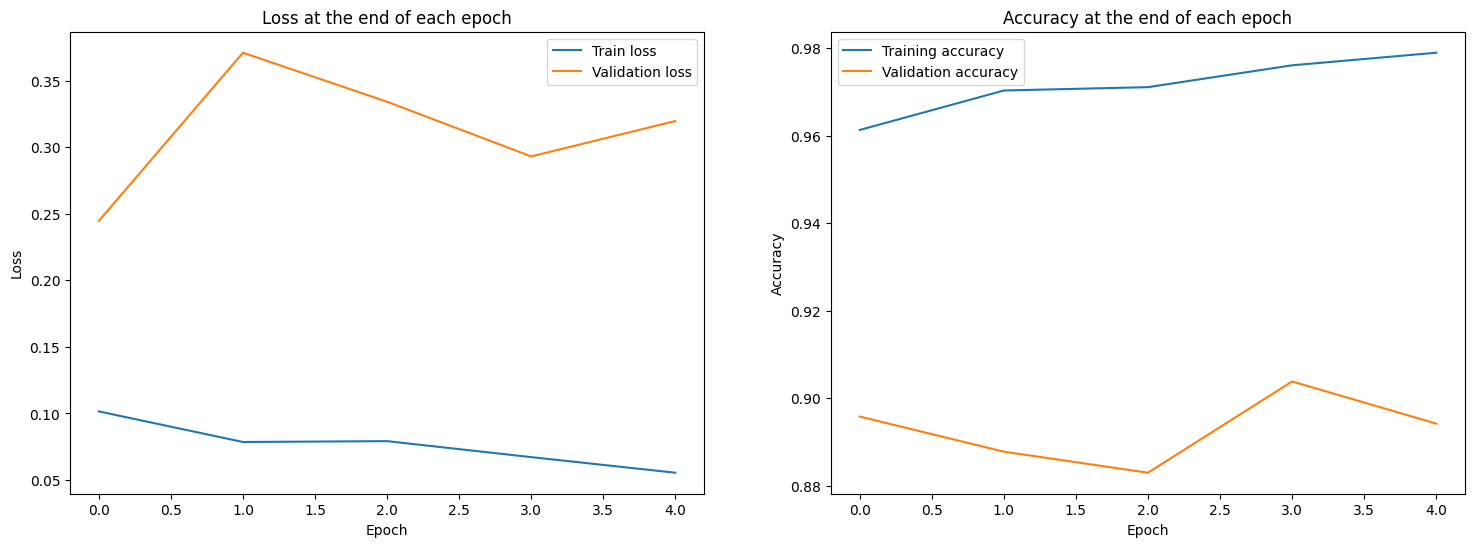

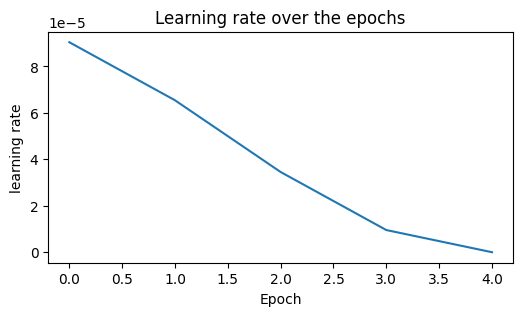

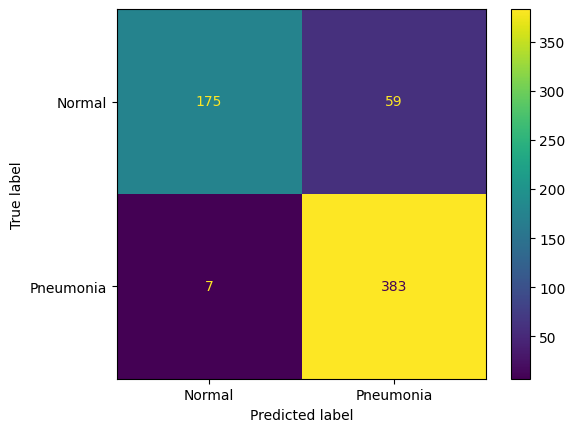

In [11]:
plot_learningcurve(metrics_history_mobilenet_final)

plot_learningrate(metrics_history_mobilenet_final['lrs'])

eval_metrics_mobilenet_final = evaluate_model(model_mobilenet_freeze, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_mobilenet_final['accuracy']:.2%}")

print(f"Precision: {eval_metrics_mobilenet_final['precision']:.2f}, Recall: {eval_metrics_mobilenet_final['recall']:.2f}, F1 score: {eval_metrics_mobilenet_final['f1']:.2f}, AUC: {eval_metrics_mobilenet_final['auc']:.2f}")

print(f'classification_report :{eval_metrics_mobilenet_final['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_mobilenet_final['confusion matrix'])

## MobileNetV2 (train all layers from beginning)
Also try to train all layers of the pretrained MobileNetV2 model from the beginning. use different learning rates for:
- backbone: lower LR
- classifier and first conv: higher LR

In [12]:
epochs = 15

model_mobilenet_all = mobilenet.get_mobilenet(pretrained=True, grayscale=True, freeze= False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW([
        {'params': model_mobilenet_all.features.parameters(), 'lr': 1e-4},
        {'params': model_mobilenet_all.classifier.parameters(), 'lr': 1e-3}
    ], weight_decay=1e-4)

metrics_history_mobilenet_all = train_model(model_mobilenet_all,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 15:


Training: 100%|██████████| 163/163 [12:57<00:00,  4.77s/it]


  Average train loss:0.222878  
 Accuracy on the train dataset: 91.37%


Validation: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


  Average val loss:0.315196  
 Accuracy on the validation dataset: 89.42%
 Epoch 2 / 15:


Training: 100%|██████████| 163/163 [11:31<00:00,  4.24s/it]


  Average train loss:0.103164  
 Accuracy on the train dataset: 96.15%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


  Average val loss:0.284577  
 Accuracy on the validation dataset: 89.42%
 Epoch 3 / 15:


Training: 100%|██████████| 163/163 [10:50<00:00,  3.99s/it]


  Average train loss:0.092810  
 Accuracy on the train dataset: 96.74%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


  Average val loss:0.316599  
 Accuracy on the validation dataset: 90.06%
 Epoch 4 / 15:


Training: 100%|██████████| 163/163 [10:58<00:00,  4.04s/it]


  Average train loss:0.074306  
 Accuracy on the train dataset: 97.41%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


  Average val loss:0.251241  
 Accuracy on the validation dataset: 91.99%
 Epoch 5 / 15:


Training: 100%|██████████| 163/163 [10:56<00:00,  4.03s/it]


  Average train loss:0.066881  
 Accuracy on the train dataset: 97.55%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


  Average val loss:0.227424  
 Accuracy on the validation dataset: 92.79%
 Epoch 6 / 15:


Training: 100%|██████████| 163/163 [10:46<00:00,  3.97s/it]


  Average train loss:0.058784  
 Accuracy on the train dataset: 97.97%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


  Average val loss:0.278546  
 Accuracy on the validation dataset: 92.47%
 Epoch 7 / 15:


Training: 100%|██████████| 163/163 [10:53<00:00,  4.01s/it]


  Average train loss:0.054664  
 Accuracy on the train dataset: 98.03%


Validation: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


  Average val loss:0.321626  
 Accuracy on the validation dataset: 90.71%
 Epoch 8 / 15:


Training: 100%|██████████| 163/163 [11:25<00:00,  4.20s/it]


  Average train loss:0.044123  
 Accuracy on the train dataset: 98.47%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


  Average val loss:0.295543  
 Accuracy on the validation dataset: 92.79%
 Epoch 9 / 15:


Training: 100%|██████████| 163/163 [11:08<00:00,  4.10s/it]


  Average train loss:0.038341  
 Accuracy on the train dataset: 98.68%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


  Average val loss:0.320279  
 Accuracy on the validation dataset: 91.99%
 Epoch 10 / 15:


Training: 100%|██████████| 163/163 [10:52<00:00,  4.00s/it]


  Average train loss:0.041190  
 Accuracy on the train dataset: 98.43%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


  Average val loss:0.352211  
 Accuracy on the validation dataset: 91.51%
 Epoch 11 / 15:


Training: 100%|██████████| 163/163 [10:56<00:00,  4.03s/it]


  Average train loss:0.034309  
 Accuracy on the train dataset: 98.87%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


  Average val loss:0.416755  
 Accuracy on the validation dataset: 90.38%
 Epoch 12 / 15:


Training: 100%|██████████| 163/163 [10:52<00:00,  4.01s/it]


  Average train loss:0.031872  
 Accuracy on the train dataset: 98.73%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


  Average val loss:0.330204  
 Accuracy on the validation dataset: 92.15%
 Epoch 13 / 15:


Training: 100%|██████████| 163/163 [10:46<00:00,  3.97s/it]


  Average train loss:0.029921  
 Accuracy on the train dataset: 98.93%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.397648  
 Accuracy on the validation dataset: 91.67%
 Epoch 14 / 15:


Training: 100%|██████████| 163/163 [10:44<00:00,  3.95s/it]


  Average train loss:0.031157  
 Accuracy on the train dataset: 98.85%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.437067  
 Accuracy on the validation dataset: 90.71%
 Epoch 15 / 15:


Training: 100%|██████████| 163/163 [10:37<00:00,  3.91s/it]


  Average train loss:0.028063  
 Accuracy on the train dataset: 99.14%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

  Average val loss:0.464200  
 Accuracy on the validation dataset: 91.67%
Done!


### Save the model

In [13]:
torch.save(model_mobilenet_all.state_dict(),'../models/mobilenet_train_all_10ep_weights.pth')

### Results

Validation: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Accuracy on the test set: 91.67%
Precision: 0.89, Recall: 0.98, F1 score: 0.94, AUC: 0.89
classification_report :              precision    recall  f1-score   support

           0       0.96      0.81      0.88       234
           1       0.89      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624



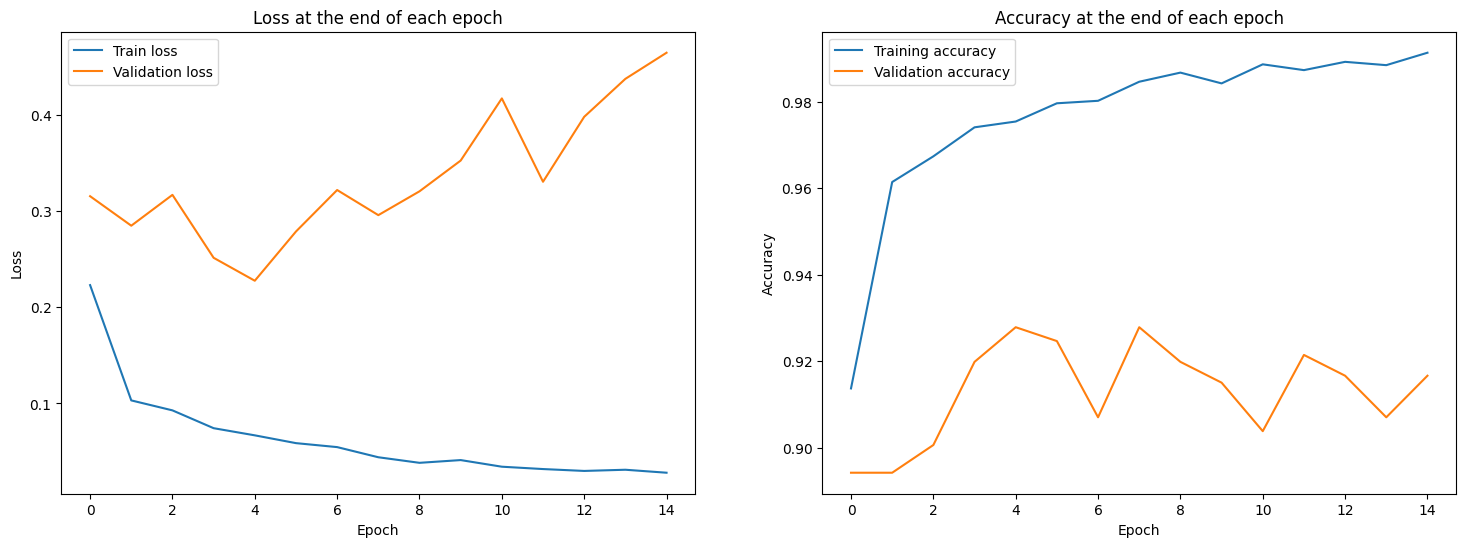

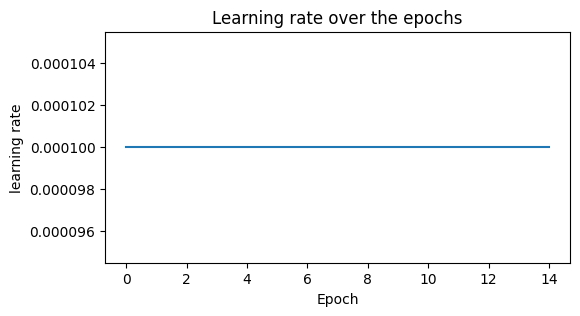

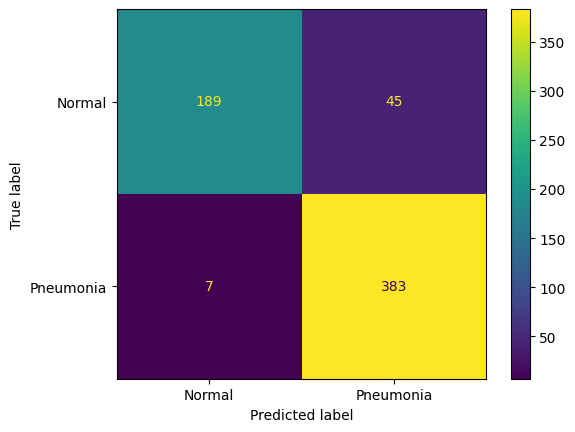

In [15]:
plot_learningcurve(metrics_history_mobilenet_all)

plot_learningrate(metrics_history_mobilenet_all['lrs'])

eval_metrics_mobilenet_all = evaluate_model(model_mobilenet_all, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_mobilenet_all['accuracy']:.2%}")

print(f"Precision: {eval_metrics_mobilenet_all['precision']:.2f}, Recall: {eval_metrics_mobilenet_all['recall']:.2f}, F1 score: {eval_metrics_mobilenet_all['f1']:.2f}, AUC: {eval_metrics_mobilenet_all['auc']:.2f}")

print(f'classification_report :{eval_metrics_mobilenet_all['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_mobilenet_all['confusion matrix'])